In [1]:
#configurations
epochs = 1

activationFunctions = dict()
activationFunctions["conv1"] = "ReLU"
activationFunctions["conv2"] = "ReLU"
activationFunctions["conv3"] = "ReLU"
activationFunctions["conv4"] = "ReLU"
activationFunctions["conv5"] = "ReLU"
activationFunctions["fc1"] = "ReLU"
list_kernelSize= [3]*5
listDropout = [0,0,0.5]
kernelNumber = [32,32]+[64,64]+[128]
classes = 10
learningRate = 1e-4
nodesfc1 = 1024
lr_schedule = 1 # per 10 epochs half the learningRate


# Imports

In [2]:
import torch
import torch.nn as nn
import shutil
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import math
import torchvision
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
import wandb
from torchvision.transforms import RandomCrop, RandomResizedCrop, RandomHorizontalFlip, Resize, CenterCrop, ToTensor, Normalize, Compose


# Loading the data

In [3]:
def loader(t1data,valdata,t2data,batch):
    bs=batch
    bool=True
    bool2=False
    allLoaders = {
        'train' : torch.utils.data.DataLoader(t1data, batch_size=bs,num_workers = 4, shuffle=bool) ,
        'valid' : torch.utils.data.DataLoader(valdata, batch_size=bs,num_workers = 4,  shuffle=bool) ,
        'test'  : torch.utils.data.DataLoader(t2data, batch_size=bs,num_workers = 4,  shuffle=bool2)
    }
    return allLoaders


## transforms to match realModel input dimensions
def transform():
    string ='Normalize'
    valResize = 256 #134 #36
    sizeChange = 224 #128#32
    valCenterCrop = sizeChange
    
   
    
    t1_t = Compose([RandomResizedCrop(sizeChange),
                       RandomHorizontalFlip(),
                       ToTensor(),
                       Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    val_t = Compose([Resize(valResize),
                       CenterCrop(valCenterCrop),
                       ToTensor(),
                       Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    t2_t = Compose([Resize((sizeChange,sizeChange)), 
                      ToTensor(), 
                      Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    
    transforms = {
        'training':   t1_t,
        'validation': val_t,
        'test': t2_t
    }
    
    return transforms

# Loading the dataset function
def data_load():
    transforms=transform()
    t1set  = torchvision.datasets.ImageFolder('/kaggle/input/dlass2/inaturalist_12K/train', transforms['training'])
    train, val = random_split(t1set, [8000, 1999])
    t2set   = torchvision.datasets.ImageFolder('/kaggle/input/dlass2/inaturalist_12K/val', transforms['test'])
    lables = t1set.classes
    return train, val, t2set, lables

In [4]:
# check if CUDA is available
cuda = torch.cuda.is_available()
if cuda == True:
    device = torch.device("cuda")
if cuda != True:
    device = torch.device("cpu")
    
print(device)

cuda


In [5]:
modelName = 'Best_CNN_5Layers_iNaturalist'

In [6]:
# !wandb login 6a66920f640c7001ec17ad4aa7a5da8b378aee61

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [7]:
batch = 64
dataT1, dataVal, dataT2, lables = data_load()
allLoaders = loader(dataT1, dataVal, dataT2,  batch)

# Get Optimizers

In [8]:
def activationFun(activation):
    act=activation
    if activation.lower() == 'relu':
        return nn.ReLU()
    elif activation.lower() == 'gelu':
        return nn.GELU()
    elif activation.lower() == 'elu':
        return nn.ELU()
    elif activation.lower() == 'silu':
        return nn.SiLU()
    elif activation.lower() == 'mish':
        return nn.Mish()
    elif activation.lower() == 'leakyrelu':
        return nn.LeakyReLU()
    

In [9]:
class blockConv(nn.Module):
    def __init__(self,channelsIn,channelsOut,kernel= 3 , BN=True , NL="ReLU",stride = 1, padding = 0):
        KL=channelsOut
        super(blockConv, self).__init__()
        self.BN,self.NL=BN,NL
        bol=False
        self.conv = nn.Conv2d(channelsIn, channelsOut, kernel_size= kernel , stride = stride, padding = padding, bias=bol)
        bol=self.BN==True
        if bol:
            val=0.001
            self.bn = nn.BatchNorm2d(channelsOut, eps=val)
        self.act = activationFun(NL)
        
    def forward(self, x):
        x = self.conv(x)
        bol=self.BN==True
        if bol:
            x = self.bn(x)
        
        return self.act(x)




In [10]:
class fc_block(nn.Module):
    runs=1
    def __init__( self , channelsIn ,channelsOut , BN=False , NL="relu"):
        x=channelsOut
        super(fc_block, self).__init__()
        self.fc = nn.Linear(channelsIn, channelsOut)
        self.BN,self.NL=BN,NL
       
        bol=self.BN==True
        if bol:
            value=0.001
            self.bn = nn.BatchNorm2d(channelsOut, eps=value)    
        self.act = activationFun(NL)
        
    def forward(self, x):
        x = self.fc(x)
        bol = self.BN==True
        if bol:
            value=0.001
            x = self.bn(x)
        x = self.act(x)
        
        return x



In [11]:
def get_fc_in(dim, list_kernelSize, kernelNumber):
    fc_in = dim - list_kernelSize[0] + 1 # conv1
    val=(fc_in - 2) //2  + 1
    fc_in = val # max pool 1

    s=1
    while s < 5:
        fc_in = fc_in - list_kernelSize[s] + 1 # conv2
        val1=(fc_in - 2) //2  + 1 
        fc_in =val1# max pool 
        s=s+1 
    
    val2=fc_in * fc_in
    ans= val2 * kernelNumber[4]
    return ans


# CNN Class

In [12]:
class CNN_5layer(nn.Module):
    def __init__( self,list_kernelSize , kernelNumber , activationFunctions , listDropout, nodesfc1, classes):
        list1=list_kernelSize
        super(CNN_5layer, self).__init__()
        self.listDropout = listDropout
        bol2=False
        self.dim = 224
        self.conv1 = nn.Sequential(blockConv(3 , kernelNumber[0], kernel=list_kernelSize[0], BN=bol2, NL=activationFunctions['conv1']),nn.MaxPool2d((2, 2)))
        bol1=True
        

        self.conv2 = nn.Sequential(blockConv(kernelNumber[0], kernelNumber[1], kernel=list_kernelSize[1], BN=bol1, NL=activationFunctions['conv2']),nn.MaxPool2d((2, 2)))
        bol=self.listDropout[0]!=0
        if bol:
            self.dropout1 = nn.Dropout(listDropout[0])

        self.conv3 = nn.Sequential(blockConv(kernelNumber[1], kernelNumber[2], kernel=list_kernelSize[2], BN=bol1, NL=activationFunctions['conv3']),nn.MaxPool2d((2, 2)))
        self.conv4 = nn.Sequential(blockConv(kernelNumber[2], kernelNumber[3], kernel=list_kernelSize[3], BN=bol1, NL=activationFunctions['conv4']),nn.MaxPool2d((2, 2)))
        bol=self.listDropout[1]!=0
        if bol:
            self.dropout2 = nn.Dropout(listDropout[1])

        self.conv5 = nn.Sequential(blockConv(kernelNumber[3], kernelNumber[4], kernel=list_kernelSize[4], BN=bol1, NL=activationFunctions['conv5']),nn.MaxPool2d((2, 2)))
        kernel_size=kernelNumber[3]
        self.fc1_in_features = get_fc_in(self.dim, list_kernelSize, kernelNumber)
        kernel_size=list_kernelSize
        self.fc1 = fc_block(self.fc1_in_features, nodesfc1 , NL=activationFunctions['fc1'])
        bol=self.listDropout[2]!=0
        if bol:
            self.dropout3 = nn.Dropout(listDropout[2])
        
        self.fc2 = nn.Linear(nodesfc1, classes)
    
    
    def forward(self, x):
        bol=x.shape[2]!=self.dim
        if bol:
            print("input dim not matched")
            return
        x = self.conv1(x)
        x = self.conv2(x)
        
        bol=self.listDropout[0]!=0
        if bol:
            x = self.dropout1(x)

        x = self.conv3(x)
        
        x = self.conv4(x)
        
        bol=self.listDropout[1]!=0
        if bol:
            x = self.dropout2(x)
        y=x
        x = self.conv5(x)
        y=x.shape[0]
        x = x.view(y, -1)
        
        x = self.fc1(x)
        bol=self.listDropout[2]!=0
        if bol:
            x = self.dropout3(x)
        
        x = self.fc2(x)
        
        return x

In [13]:
realModel = CNN_5layer(list_kernelSize, kernelNumber, activationFunctions, listDropout, nodesfc1, classes)
realModel = realModel.to(device)

In [14]:
bol=False
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(realModel.parameters(), lr=learningRate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=bol)
scheduler = StepLR(opt, step_size=10, gamma=lr_schedule)


# Train Model

In [15]:

def train(totalEpoch, allLoaders, realModel, opt, criterion,scheduler, cuda):
    
    for epoch in range(totalEpoch):
        
        train_loss ,valid_loss= 0.0,0.0
        
        
        
         
        realModel.train()
        tnum_correct,tnum_examples=0,0
        for data, target in allLoaders['train']:
            # move to GPU
            bol=cuda
            if bol:
                data, target = data.cuda(), target.cuda()
                
            opt.zero_grad()
            
            output = realModel(data)
            loss = criterion(output, target)
            
            
            loss.backward()
            opt.step()
            train_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            tnum_examples += target.size(0)
            tnum_correct += (predicted == target).sum().item()
            
        train_acc = (tnum_correct / tnum_examples) * 100
        train_loss = train_loss / len(allLoaders['train'])

        
          
    
        
        realModel.eval()
        num_correct ,num_examples= 0,0
        
        
        
        for data, target in allLoaders['valid']:
            bol=cuda
            if bol:
                data, target = data.cuda(), target.cuda()
            
            output = realModel(data)
            loss = criterion(output, target)
            
            
            
            valid_loss += loss.item()
            
            _, val_predicted = torch.max(output.data, 1)
            num_examples += target.size(0)
            num_correct += (val_predicted == target).sum().item()
           

        valid_acc = (num_correct / num_examples) * 100
        valid_loss = valid_loss / len(allLoaders['valid'])
        
        scheduler.step()
        
        print('Epoch: {}\tTraining Loss: {:.6f}\tTrain Accuracy: {:.2f}\tValidation Loss: {:.6f}\tvalidation Accuracy: {:.2f}'.format(
            epoch, 
            train_loss,
            train_acc,
            valid_loss,
            valid_acc
            ))
        
        # wandb.log({'epoch': epoch,'train loss': train_loss,'train accuracy': train_acc,
        #            'val loss': valid_loss, 'val accuracy': valid_acc})
        
   
    return realModel, valid_acc

In [16]:
trained_model,_ = train(
                      totalEpoch = epochs,
                      allLoaders = allLoaders,
                      realModel = realModel,
                      opt = opt,
                      criterion = criterion,
                      scheduler = scheduler,
                      cuda = cuda
                     )

Epoch: 0	Training Loss: 2.197546	Train Accuracy: 18.88	Validation Loss: 2.101623	validation Accuracy: 24.76


# Question 2

In [23]:
def config_str_list_int(s):
    l=1
    return list(map(int, s[3:].split('-')))

def config_str_list_float(s):
    l=1
    return list(map(float, s.split('-')))

In [78]:
def sp_train():
    runs=1
    configdefaults = {
        'epochs': 2,
        'kernel_size_config':'1) 5-5-3-3-3' ,
        'no_kernel_config':'1) 16-16-16-16-16',
        'dropout_config':'0-0-0.4',
        'fc1_nodes': 32,
        'batch_size': 64
    }
    # starting a wandb run

    wandb.init(config=configdefaults)
    start =0
    config = wandb.config
    epachs=2
    sizes= config.kernel_size_config
    numbers=config.no_kernel_config
    dropout=config.dropout_config
    str1=str(config.fc1_nodes)
    batchsize=str(32)
    run_name="kSizes:["+sizes+"] kNumbers:["+numbers+"] dp:["+dropout+"] fc1:["+str1+"] bs:["+batchsize+"]"
    wandb.run.name=run_name
    
   
    model = CNN_5layer(config_str_list_int(config.kernel_size_config),
                       config_str_list_int(config.no_kernel_config),
                       {
        'conv1':'relu',
        'conv2':'relu',
        'conv3':'relu',
        'conv4':'relu',
        'conv5':'relu',
        'fc1':'relu'
        },
                       config_str_list_float(config.dropout_config),
                       config.fc1_nodes, 10).to(device)

    opti = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    trained_model,val_accuracy = train(
                      totalEpoch = config.epochs,
                      allLoaders = allLoaders,
                      realModel = model,
                      opt = opti,
                      criterion = nn.CrossEntropyLoss(),
                      scheduler = StepLR(opti, step_size=10, gamma=0.5),
                      cuda = cuda
                     )
    wandb.log({'val_accuracy':val_accuracy})
    

In [30]:
'''def sp_train():
    runs=1
    configdefaults = {
        'epochs': 2,
        'kernel_size_config':'1) 5-5-3-3-3' ,
        'no_kernel_config':'1) 16-16-16-16-16',
        'dropout_config':'0-0-0.3',
        'fc1_nodes': 32,
        'batch_size': 64
    }
    # starting a wandb run

    wandb.init(config=configdefaults)
    start =0
    config = wandb.config
    epachs=2
    sizes= '1) 3-3-3-3-3'
    numbers='2) 32-32-64-64-128'
    dropout='0-0-0.3'
    str1=str(1024)
    batchsize=str(32)
    run_name="kSizes:["+sizes+"] kNumbers:["+numbers+"] dp:["+dropout+"] fc1:["+str1+"] bs:["+batchsize+"]"
    wandb.run.name=run_name
    
   
    model = CNN_5layer(config_str_list_int('1) 3-3-3-3-3'),
                       config_str_list_int('2) 32-32-64-64-128'),
                       {
        'conv1':'relu',
        'conv2':'relu',
        'conv3':'relu',
        'conv4':'relu',
        'conv5':'relu',
        'fc1':'relu'
        },
                       config_str_list_float('0-0-0.3'),
                       1024, 10).to(device)

    opti = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    trained_model,val_accuracy = train(
                      totalEpoch = config.epochs,
                      allLoaders = allLoaders,
                      realModel = model,
                      opt = opti,
                      criterion = nn.CrossEntropyLoss(),
                      scheduler = StepLR(opti, step_size=10, gamma=0.5),
                      cuda = cuda
                     )
    wandb.log({'val_accuracy':val_accuracy})'''
    

In [25]:
sweep_config = {
    'name' : 'DL Assigment 2 Part-A',
    'method': 'bayes', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': dict({
        'kernel_size_config':{
            'values': ['1) 5-5-3-3-3', 
                       '2) 3-3-3-3-3', 
                       '3) 3-3-3-5-5'
                       ]
        },
        'no_kernel_config': {
            'values': [ 
                      '1) 64-64-32-32-16', 
                      '2) 32-32-64-64-128']
        },
        'dropout_config':{
            'values':['0-0-0.5','0-0-0.3']
        },
        'optimizer' : {'values' : [ 'sgd','adam', 'adagrad']},
        'activation' : {'values': ['ReLU', 'SiLU', 'GeLU',  'LeakyReLU' , 'Mish']},
        'data_aug' : {'values': ['Yes', 'No']},
        'batch_norm' : {'values': ['Yes', 'No']},
        'fc1_nodes':{
            'values': [512,1024]
        },
        'batch_size': {
            'values':[32, 64]
        },
        'epochs': {
            'values':[20, 10]
        },        
    })
}

In [26]:
sweep_id = wandb.sweep(sweep_config, project='DL-Assignment-2')

In [29]:
wandb.agent(sweep_id, sp_train,count=10)

wandb: Agent Starting Run: 0z1m4mrx with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 512
wandb: 	kernel_size_config: 3) 3-3-3-5-5
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad
wandb: Currently logged in as: cs24m019 (cs24m019-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch: 0	Training Loss: 2.161399	Train Accuracy: 21.27	Validation Loss: 2.084485	validation Accuracy: 23.61
Epoch: 1	Training Loss: 2.060377	Train Accuracy: 26.50	Validation Loss: 2.040999	validation Accuracy: 26.66
Epoch: 2	Training Loss: 2.027274	Train Accuracy: 27.61	Validation Loss: 1.997186	validation Accuracy: 28.41
Epoch: 3	Training Loss: 1.981888	Train Accuracy: 29.58	Validation Loss: 1.975540	validation Accuracy: 28.46
Epoch: 4	Training Loss: 1.963681	Train Accuracy: 30.36	Validation Loss: 1.954059	validation Accuracy: 29.76
Epoch: 5	Training Loss: 1.936255	Train Accuracy: 31.13	Validation Loss: 1.970864	validation Accuracy: 28.81
Epoch: 6	Training Loss: 1.918636	Train Accuracy: 32.69	Validation Loss: 2.045370	validation Accuracy: 28.41
Epoch: 7	Training Loss: 1.910132	Train Accuracy: 32.79	Validation Loss: 1.924633	validation Accuracy: 31.77
Epoch: 8	Training Loss: 1.883604	Train Accuracy: 33.66	Validation Loss: 1.909930	validation Accuracy: 31.92
Epoch: 9	Training Loss: 1.86

val_accuracy,▁
val_accuracy,37.26863


wandb: Agent Starting Run: lh5jy0vg with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 10
wandb: 	fc1_nodes: 1024
wandb: 	kernel_size_config: 3) 3-3-3-5-5
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.168040	Train Accuracy: 21.40	Validation Loss: 2.113941	validation Accuracy: 23.76
Epoch: 1	Training Loss: 2.074748	Train Accuracy: 25.37	Validation Loss: 2.084850	validation Accuracy: 23.46
Epoch: 2	Training Loss: 2.025968	Train Accuracy: 28.10	Validation Loss: 2.074613	validation Accuracy: 24.61
Epoch: 3	Training Loss: 1.992366	Train Accuracy: 29.11	Validation Loss: 2.011813	validation Accuracy: 28.31
Epoch: 4	Training Loss: 1.960751	Train Accuracy: 30.71	Validation Loss: 1.997682	validation Accuracy: 28.46
Epoch: 5	Training Loss: 1.944413	Train Accuracy: 31.26	Validation Loss: 1.967946	validation Accuracy: 29.71
Epoch: 6	Training Loss: 1.918660	Train Accuracy: 31.72	Validation Loss: 2.001661	validation Accuracy: 28.21
Epoch: 7	Training Loss: 1.892463	Train Accuracy: 33.58	Validation Loss: 1.984646	validation Accuracy: 30.47
Epoch: 8	Training Loss: 1.875295	Train Accuracy: 33.65	Validation Loss: 1.995546	validation Accuracy: 29.11
Epoch: 9	Training Loss: 1.86

val_accuracy,▁
val_accuracy,31.26563


wandb: Agent Starting Run: swq5v0fh with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: Yes
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 10
wandb: 	fc1_nodes: 1024
wandb: 	kernel_size_config: 3) 3-3-3-5-5
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.161842	Train Accuracy: 21.65	Validation Loss: 2.062239	validation Accuracy: 24.96
Epoch: 1	Training Loss: 2.057312	Train Accuracy: 26.94	Validation Loss: 2.061316	validation Accuracy: 26.41
Epoch: 2	Training Loss: 2.014011	Train Accuracy: 28.65	Validation Loss: 2.009223	validation Accuracy: 28.31
Epoch: 3	Training Loss: 1.982053	Train Accuracy: 30.19	Validation Loss: 1.992420	validation Accuracy: 27.81
Epoch: 4	Training Loss: 1.940108	Train Accuracy: 31.64	Validation Loss: 1.948416	validation Accuracy: 31.07
Epoch: 5	Training Loss: 1.927832	Train Accuracy: 32.04	Validation Loss: 1.977113	validation Accuracy: 28.46
Epoch: 6	Training Loss: 1.894134	Train Accuracy: 33.61	Validation Loss: 1.923530	validation Accuracy: 32.42
Epoch: 7	Training Loss: 1.880869	Train Accuracy: 34.17	Validation Loss: 1.907565	validation Accuracy: 31.77
Epoch: 8	Training Loss: 1.861095	Train Accuracy: 34.58	Validation Loss: 1.906334	validation Accuracy: 32.02
Epoch: 9	Training Loss: 1.84

val_accuracy,▁
val_accuracy,32.96648


wandb: Agent Starting Run: kv6qdl0i with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 1024
wandb: 	kernel_size_config: 2) 3-3-3-3-3
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.155361	Train Accuracy: 21.99	Validation Loss: 2.064620	validation Accuracy: 25.46
Epoch: 1	Training Loss: 2.046535	Train Accuracy: 27.38	Validation Loss: 2.037761	validation Accuracy: 26.51
Epoch: 2	Training Loss: 2.007975	Train Accuracy: 28.69	Validation Loss: 1.994207	validation Accuracy: 28.71
Epoch: 3	Training Loss: 1.968740	Train Accuracy: 30.78	Validation Loss: 2.016210	validation Accuracy: 29.51
Epoch: 4	Training Loss: 1.933707	Train Accuracy: 31.76	Validation Loss: 1.970087	validation Accuracy: 28.86
Epoch: 5	Training Loss: 1.911790	Train Accuracy: 31.90	Validation Loss: 1.943423	validation Accuracy: 30.67
Epoch: 6	Training Loss: 1.885212	Train Accuracy: 32.88	Validation Loss: 1.949191	validation Accuracy: 31.72
Epoch: 7	Training Loss: 1.865498	Train Accuracy: 34.70	Validation Loss: 1.940812	validation Accuracy: 30.72
Epoch: 8	Training Loss: 1.841891	Train Accuracy: 35.79	Validation Loss: 1.905269	validation Accuracy: 33.32
Epoch: 9	Training Loss: 1.83

val_accuracy,▁
val_accuracy,36.56828


wandb: Agent Starting Run: hch0kyx6 with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 512
wandb: 	kernel_size_config: 3) 3-3-3-5-5
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.160506	Train Accuracy: 21.56	Validation Loss: 2.122115	validation Accuracy: 23.26
Epoch: 1	Training Loss: 2.056626	Train Accuracy: 26.49	Validation Loss: 2.040587	validation Accuracy: 26.76
Epoch: 2	Training Loss: 2.011400	Train Accuracy: 27.79	Validation Loss: 1.997031	validation Accuracy: 28.06
Epoch: 3	Training Loss: 1.972546	Train Accuracy: 30.49	Validation Loss: 1.952939	validation Accuracy: 29.31
Epoch: 4	Training Loss: 1.947520	Train Accuracy: 31.20	Validation Loss: 1.954677	validation Accuracy: 30.32
Epoch: 5	Training Loss: 1.928699	Train Accuracy: 31.39	Validation Loss: 1.932394	validation Accuracy: 31.62
Epoch: 6	Training Loss: 1.897676	Train Accuracy: 32.91	Validation Loss: 1.955096	validation Accuracy: 30.32
Epoch: 7	Training Loss: 1.865480	Train Accuracy: 34.31	Validation Loss: 1.911798	validation Accuracy: 30.47
Epoch: 8	Training Loss: 1.869453	Train Accuracy: 33.69	Validation Loss: 1.875047	validation Accuracy: 32.47
Epoch: 9	Training Loss: 1.84

val_accuracy,▁
val_accuracy,36.16808


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xd3w8g2j with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 512
wandb: 	kernel_size_config: 3) 3-3-3-5-5
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.159821	Train Accuracy: 21.81	Validation Loss: 2.076800	validation Accuracy: 24.51
Epoch: 1	Training Loss: 2.066966	Train Accuracy: 25.95	Validation Loss: 2.038394	validation Accuracy: 26.21
Epoch: 2	Training Loss: 2.014916	Train Accuracy: 28.14	Validation Loss: 2.002178	validation Accuracy: 27.36
Epoch: 3	Training Loss: 1.995368	Train Accuracy: 28.76	Validation Loss: 1.987634	validation Accuracy: 28.51
Epoch: 4	Training Loss: 1.950400	Train Accuracy: 30.41	Validation Loss: 1.935659	validation Accuracy: 29.71
Epoch: 5	Training Loss: 1.918970	Train Accuracy: 32.45	Validation Loss: 1.953944	validation Accuracy: 30.57
Epoch: 6	Training Loss: 1.909851	Train Accuracy: 33.00	Validation Loss: 1.935880	validation Accuracy: 30.32
Epoch: 7	Training Loss: 1.895930	Train Accuracy: 32.90	Validation Loss: 1.983166	validation Accuracy: 29.86
Epoch: 8	Training Loss: 1.863501	Train Accuracy: 33.91	Validation Loss: 1.963580	validation Accuracy: 31.27
Epoch: 9	Training Loss: 1.85

val_accuracy,▁
val_accuracy,36.66833


wandb: Agent Starting Run: 2ehdgy4i with config:
wandb: 	activation: GeLU
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 1024
wandb: 	kernel_size_config: 2) 3-3-3-3-3
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.162060	Train Accuracy: 22.11	Validation Loss: 2.104933	validation Accuracy: 24.36
Epoch: 1	Training Loss: 2.056454	Train Accuracy: 26.57	Validation Loss: 2.037988	validation Accuracy: 26.46
Epoch: 2	Training Loss: 2.003744	Train Accuracy: 29.21	Validation Loss: 2.020343	validation Accuracy: 27.56
Epoch: 3	Training Loss: 1.965619	Train Accuracy: 30.43	Validation Loss: 1.976833	validation Accuracy: 29.81
Epoch: 4	Training Loss: 1.948072	Train Accuracy: 30.83	Validation Loss: 1.961901	validation Accuracy: 27.51
Epoch: 5	Training Loss: 1.918205	Train Accuracy: 32.45	Validation Loss: 1.943117	validation Accuracy: 30.47
Epoch: 6	Training Loss: 1.898306	Train Accuracy: 33.30	Validation Loss: 1.975319	validation Accuracy: 30.12
Epoch: 7	Training Loss: 1.878990	Train Accuracy: 33.86	Validation Loss: 2.058430	validation Accuracy: 27.46
Epoch: 8	Training Loss: 1.855231	Train Accuracy: 34.85	Validation Loss: 1.947813	validation Accuracy: 31.57
Epoch: 9	Training Loss: 1.84

val_accuracy,▁
val_accuracy,35.31766


wandb: Agent Starting Run: nwk9z9fu with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: Yes
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 1024
wandb: 	kernel_size_config: 3) 3-3-3-5-5
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.174981	Train Accuracy: 21.14	Validation Loss: 2.065606	validation Accuracy: 25.61
Epoch: 1	Training Loss: 2.048952	Train Accuracy: 26.86	Validation Loss: 2.024468	validation Accuracy: 27.96
Epoch: 2	Training Loss: 2.008593	Train Accuracy: 28.56	Validation Loss: 2.050007	validation Accuracy: 25.16
Epoch: 3	Training Loss: 1.964154	Train Accuracy: 29.91	Validation Loss: 2.041855	validation Accuracy: 26.51
Epoch: 4	Training Loss: 1.950315	Train Accuracy: 31.65	Validation Loss: 1.965358	validation Accuracy: 29.21
Epoch: 5	Training Loss: 1.913497	Train Accuracy: 32.48	Validation Loss: 1.980544	validation Accuracy: 29.76
Epoch: 6	Training Loss: 1.899266	Train Accuracy: 32.90	Validation Loss: 2.023602	validation Accuracy: 28.26
Epoch: 7	Training Loss: 1.883032	Train Accuracy: 33.64	Validation Loss: 1.903476	validation Accuracy: 32.82
Epoch: 8	Training Loss: 1.863468	Train Accuracy: 34.12	Validation Loss: 1.921008	validation Accuracy: 30.92
Epoch: 9	Training Loss: 1.83

val_accuracy,▁
val_accuracy,34.16708


wandb: Agent Starting Run: 62zb79ka with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_norm: No
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 1024
wandb: 	kernel_size_config: 2) 3-3-3-3-3
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.172497	Train Accuracy: 20.56	Validation Loss: 2.116396	validation Accuracy: 23.51
Epoch: 1	Training Loss: 2.060215	Train Accuracy: 26.56	Validation Loss: 2.015817	validation Accuracy: 26.41
Epoch: 2	Training Loss: 2.016290	Train Accuracy: 28.25	Validation Loss: 2.012597	validation Accuracy: 26.71
Epoch: 3	Training Loss: 1.997076	Train Accuracy: 29.40	Validation Loss: 1.990830	validation Accuracy: 28.26
Epoch: 4	Training Loss: 1.961481	Train Accuracy: 30.24	Validation Loss: 1.991343	validation Accuracy: 29.11
Epoch: 5	Training Loss: 1.935008	Train Accuracy: 31.18	Validation Loss: 1.995592	validation Accuracy: 27.16
Epoch: 6	Training Loss: 1.910606	Train Accuracy: 32.56	Validation Loss: 1.999232	validation Accuracy: 28.96
Epoch: 7	Training Loss: 1.890007	Train Accuracy: 32.95	Validation Loss: 1.960570	validation Accuracy: 31.57
Epoch: 8	Training Loss: 1.869239	Train Accuracy: 33.85	Validation Loss: 1.984868	validation Accuracy: 29.06
Epoch: 9	Training Loss: 1.85

val_accuracy,▁
val_accuracy,34.21711


wandb: Agent Starting Run: zheido1f with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	batch_size: 32
wandb: 	data_aug: No
wandb: 	dropout_config: 0-0-0.3
wandb: 	epochs: 20
wandb: 	fc1_nodes: 512
wandb: 	kernel_size_config: 2) 3-3-3-3-3
wandb: 	no_kernel_config: 2) 32-32-64-64-128
wandb: 	optimizer: adagrad


Epoch: 0	Training Loss: 2.177038	Train Accuracy: 21.16	Validation Loss: 2.071593	validation Accuracy: 24.31
Epoch: 1	Training Loss: 2.064522	Train Accuracy: 25.80	Validation Loss: 2.049314	validation Accuracy: 25.91
Epoch: 2	Training Loss: 2.011599	Train Accuracy: 28.48	Validation Loss: 1.982299	validation Accuracy: 29.01
Epoch: 3	Training Loss: 1.968732	Train Accuracy: 29.25	Validation Loss: 1.996698	validation Accuracy: 29.16
Epoch: 4	Training Loss: 1.954181	Train Accuracy: 30.30	Validation Loss: 1.975052	validation Accuracy: 30.42
Epoch: 5	Training Loss: 1.933798	Train Accuracy: 31.82	Validation Loss: 1.945483	validation Accuracy: 30.12
Epoch: 6	Training Loss: 1.900034	Train Accuracy: 33.09	Validation Loss: 1.934924	validation Accuracy: 31.77
Epoch: 7	Training Loss: 1.874163	Train Accuracy: 34.09	Validation Loss: 1.924058	validation Accuracy: 31.17
Epoch: 8	Training Loss: 1.875293	Train Accuracy: 33.67	Validation Loss: 1.920887	validation Accuracy: 32.02
Epoch: 9	Training Loss: 1.84

val_accuracy,▁
val_accuracy,35.31766


In [31]:
wandb.finish()

# Question 4

In [41]:
trained_model,_ = train(
                      totalEpoch = epochs,
                      allLoaders = allLoaders,
                      realModel = realModel,
                      opt = opt,
                      criterion = criterion,
                      scheduler = scheduler,
                      cuda = cuda
                     )

Epoch: 0	Training Loss: 1.979696	Train Accuracy: 29.93	Validation Loss: 2.019813	validation Accuracy: 27.36


In [47]:
trained_model.eval()
test_acc,num_correct,num_examples, test_loss = 0,0,0,0
loader=allLoaders['test']
for data, target in loader:
    
    wandb.init(project='DL-Assignment-2', name = 'test acc')
    bol=cuda
    if bol:
        data, target = data.cuda(), target.cuda()

    output = trained_model(data)
    loss = criterion(output, target)



    test_loss += loss.item()

    _, test_predicted = torch.max(output.data, 1)
    num_examples += target.size(0)
    num_correct += (test_predicted == target).sum().item()


    test_acc = (num_correct / num_examples) * 100
    test_loss = test_loss / len(loader)
    wandb.log({"Test Accuracy": test_acc})
    wandb.finish()

print('Test Accuracy of the realModel is : {}%'.format(test_acc, 2))

Test Accuracy,▁
Test Accuracy,7.8125


Test Accuracy,▁
Test Accuracy,7.03125


Test Accuracy,▁
Test Accuracy,5.72917


Test Accuracy,▁
Test Accuracy,10.54688


Test Accuracy,▁
Test Accuracy,14.6875


Test Accuracy,▁
Test Accuracy,15.625


Test Accuracy,▁
Test Accuracy,17.41071


Test Accuracy,▁
Test Accuracy,19.92188


Test Accuracy,▁
Test Accuracy,20.83333


Test Accuracy,▁
Test Accuracy,21.09375


Test Accuracy,▁
Test Accuracy,21.44886


Test Accuracy,▁
Test Accuracy,22.52604


Test Accuracy,▁
Test Accuracy,24.75962


Test Accuracy,▁
Test Accuracy,27.23214


Test Accuracy,▁
Test Accuracy,29.0625


Test Accuracy,▁
Test Accuracy,30.66406


Test Accuracy,▁
Test Accuracy,31.98529


Test Accuracy,▁
Test Accuracy,32.72569


Test Accuracy,▁
Test Accuracy,33.63487


Test Accuracy,▁
Test Accuracy,33.75


Test Accuracy,▁
Test Accuracy,33.40774


Test Accuracy,▁
Test Accuracy,33.52273


Test Accuracy,▁
Test Accuracy,33.0163


Test Accuracy,▁
Test Accuracy,32.7474


Test Accuracy,▁
Test Accuracy,31.875


Test Accuracy,▁
Test Accuracy,32.99279


Test Accuracy,▁
Test Accuracy,33.7963


Test Accuracy,▁
Test Accuracy,34.70982


Test Accuracy,▁
Test Accuracy,34.32112


Test Accuracy,▁
Test Accuracy,33.75


Test Accuracy,▁
Test Accuracy,33.21573


Test Accuracy,▁
Test Accuracy,33.25


Test Accuracy of the realModel is : 33.25%


In [48]:
train_data_path = '/kaggle/input/dlass2/inaturalist_12K/val'

In [49]:
class_folders = os.listdir(train_data_path)
ran=range(len(class_folders))
class_images = [[] for _ in ran]
en=enumerate(class_folders)
for i, folder in en:
    for image_name in random.sample( os.listdir(os.path.join(train_data_path, folder)),3):
        img = Image.open(os.path.join(os.path.join(train_data_path, folder), image_name))
        img = img.resize((256, 256))
        class_images[i].append((img, folder))

In [50]:
def get_prediction(image):
    trained_model.eval()
    transform = Compose([ Resize(( 224, 224)), ToTensor()]) 
    input_batch = transform(image).to(device).unsqueeze(0)
    with torch.no_grad():
        value = 1
    _, predicted_class = torch.max(trained_model(transform(image).to(device).unsqueeze(0)), 1)
    return predicted_class.item()

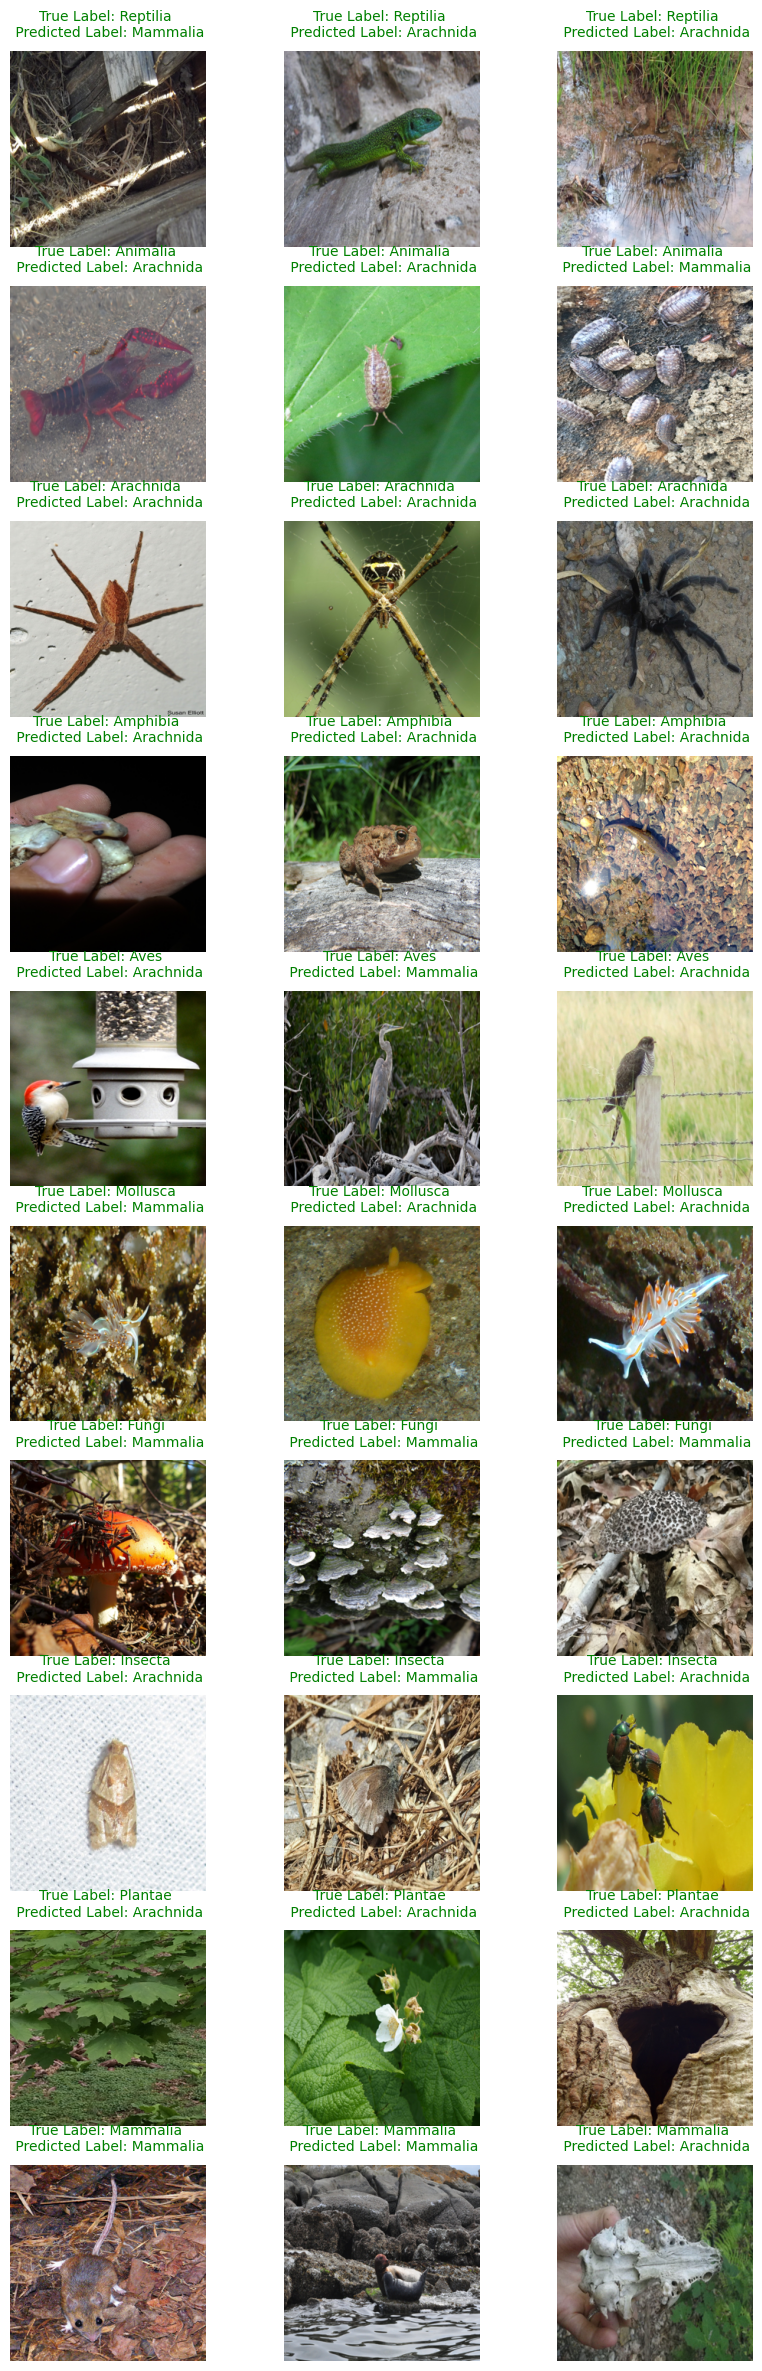

In [52]:
fig, axs = plt.subplots(10, 3, figsize=(10, 30))
i=0
while i < 10:
    j=0
    while j < 3:
        image, true_label = class_images[i][j]
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {lables[get_prediction(image)]}", fontsize=10, ha='center', pad=10, loc='center', color='green')
        j=j+1
    i+=1
wandb.init(project='DL-Assignment-2', name = 'Grid')
wandb.log({'Grid': wandb.Image(plt)})
wandb.finish()
    
plt.show()